In [117]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")  # Download the English language model, that includes tokenization, part-of-speech tagging, and lemmatization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Lab 2 - Unsupervised learning and text classification

## Part 1 - EDA, Clustering and Dimensionality reduction

### Exercise 1 Exploratory Data Analysis (EDA)

In [82]:
dataset = openml.datasets.get_dataset(43582)
df, *_ = dataset.get_data()
df

In [73]:
df.describe()

In [35]:
n = len(df.columns)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(df.columns):
    df[feature].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [36]:
print("---- Missing values ---- \n", df.isnull().sum())
print("\n\n---- Zeros ---- \n", (df == 0).sum())

There are no missing values. However, there are some anomalous values:
- Glucose
- Blood Pressure
- Skin Thickness
- Insulin
- BMI

These values cannot be zero.

In [37]:
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle('Boxplots of Each Feature')
plt.tight_layout()
plt.show()

To avoid data leackage, we only standardize the training set

In [38]:
# We split the dataset
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

numeric_cols = df.select_dtypes(include='number').columns
X_train_numeric = X_train[numeric_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)

X_train_scaled_df

### Exercise 2 - K-means Clustering

In [46]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled_df)

cluster_labels = kmeans.labels_

# Add the cluster labels to the scaled DataFrame
X_train_scaled_df['cluster'] = cluster_labels

X_train_scaled_df

In [47]:
cols = 2
rows = (len(X_train_scaled_df.columns) + cols - 1) // cols - 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i in range(len(df.columns) - 1):
    axes[i // cols, i % cols].scatter(X_train_scaled_df[df.columns[i]], X_train_scaled_df[df.columns[i+1]], c=X_train_scaled_df['cluster'])
    axes[i // cols, i % cols].set_xlabel(df.columns[i])
    axes[i // cols, i % cols].set_ylabel(df.columns[i+1])
    axes[i // cols, i % cols].set_title(f'Scatter plot of {df.columns[i]} vs {df.columns[i+1]}')

As we can see, the clusters make no sense.
We even can't see delimiter on any plot.
This means that the provided data are not really separable into K groups (here 2). Some datas don't contain useful variance.

### Exercise 3 - PCA and Visualization

In [112]:
X = X_train_scaled_df.drop(columns='cluster', errors='ignore')

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index)

X_pca_df

,PC1,PC2
60,-4.667719,0.952379
618,1.733528,1.553885
346,-1.014067,-0.939224
294,-0.701901,2.219455
231,3.090860,-0.666601
...,...,...
71,-0.036835,-0.701914
106,-1.381121,0.660538
270,2.378359,0.232023
435,-0.893289,0.075183


In [103]:
variance_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

PC1: 0.2575
PC2: 0.2005


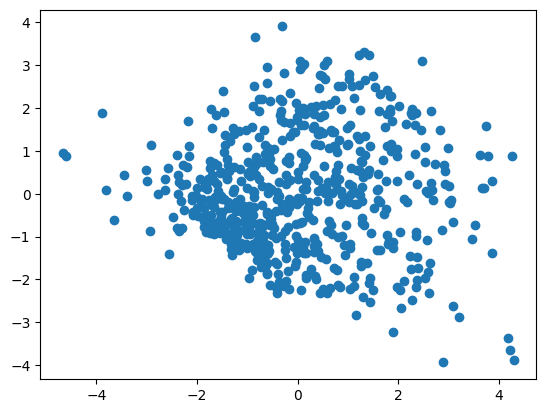

In [108]:
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'])

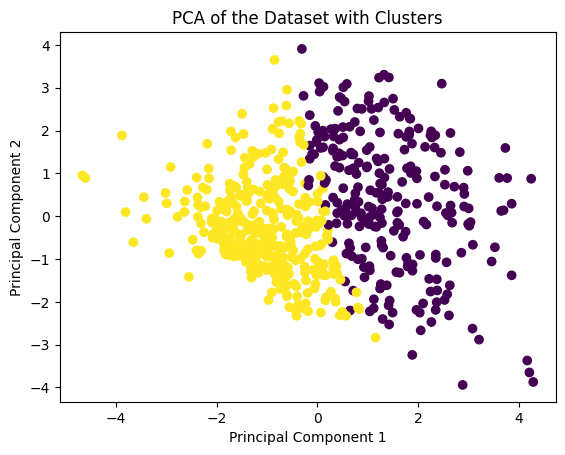

In [119]:
# We add the cluster from the previous kmeans (k=2)
if 'cluster' in X_train_scaled_df.columns:
    X_pca_df['cluster'] = X_train_scaled_df['cluster']

plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=X_pca_df['cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Dataset with Clusters')
plt.show()

In [ ]:
features = X_train_scaled_df.columns[:-1] # Exclude the cluster column

pc_loadings = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])

pc_loadings

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
PC1,0.257576,0.444710,0.303229,0.262062,0.315909,0.379471,0.220639,0.310937,0.431396
PC2,0.479065,0.073874,0.037409,-0.487533,-0.378603,-0.256670,-0.180914,0.516595,0.130885


In [127]:
pc1_top_features = pc_loadings.loc['PC1'].abs().sort_values(ascending=False)
pc2_top_features = pc_loadings.loc['PC2'].abs().sort_values(ascending=False)

print("Top features contributing to PC1:")
print(pc1_top_features.head())

print("\nTop features contributing to PC2:")
print(pc2_top_features.head())

Top features contributing to PC1:
Glucose    0.444710
Outcome    0.431396
BMI        0.379471
Insulin    0.315909
Age        0.310937
Name: PC1, dtype: float64

Top features contributing to PC2:
Age              0.516595
SkinThickness    0.487533
Pregnancies      0.479065
Insulin          0.378603
BMI              0.256670
Name: PC2, dtype: float64


## Part 2 - Text classification using Bag of Words, TF-IDF, Word2Vec and BERT embeddings 

### Exercise 1: Text Preprocessing

In [113]:
# Load the dataset using scikit-learn's fetch_20newsgroups() method
# And filter the dataset to keep only the records labeled with the computing-related categories:
# 1. comp.graphics
# 2. comp.os.ms-windows.misc
# 3. comp.sys.ibm.pc.hardware
# 4. comp.sys.mac.hardware
# 5. comp.windows.x

dataset2 = fetch_20newsgroups(subset='all', categories=[
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x'
])

target_names_dataset2 = dataset2.target_names
print(f"Target names: {target_names_dataset2}")

# Create a DataFrame with the text data and labels
df2 = pd.DataFrame({'text': dataset2.data, 'label': dataset2.target})
print(df2.head())

Target names: ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']
                                                text  label
0  From: u122743@twncu865.ncu.edu.tw\nSubject: QU...      0
1  From: miket@empros.com (Mike Tipton)\nSubject:...      1
2  From: mark@ocsmd.ocs.com (Mark Wilson)\nSubjec...      0
3  From: kiki@PROBLEM_WITH_INEWS_GATEWAY_FILE (Ke...      0
4  Organization: Queen's University at Kingston\n...      3


In [125]:
# Preprocess the text:
# o Convert the text to lowercase.
# o Remove punctuation (use regular expressions).
# o Lemmatize the words using spaCy.

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Lemmatize
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df2['text'] = df2['text'].apply(preprocess_text)
df2.head()
# 
# names.isin(categories)]
df2.describe()
data

KeyboardInterrupt: 